In [1]:
import h5py
import numpy as np
import matplotlib.colors as colors
from matplotlib import pyplot as plt
from scipy.spatial import KDTree
import pandas as pd
from astropy.constants import G
import astropy.units as u
import matplotlib
from glob import glob
import pandas as pd
import matplotlib.patches as mpatches


import matplotlib as mpl
matplotlib.matplotlib_fname()
mpl.rc_file('../Mike_rc_params')

In [4]:
file_1 = "snaps/YSOobjects/snapshot_3000.YSOobjects.hdf5"

file_2 = "snaps/test_high_dustemission/snapshot_3000.dustemission.hdf5" 

In [5]:
file_1

'snaps/YSOobjects/snapshot_3000.YSOobjects.hdf5'

In [1]:
def SFE_values_AGN(path1,path2, Box_Size, R_I, R_F):
    #Getting YSO Coordinates
    with h5py.File(path1, "r") as A:
        YSO_X = (A["X_pc"][:])
        YSO_Y = (A["Y_pc"][:])
        YSO_Mass = (A["Masses"][:])

    #Getting Dust Coordinates
    with h5py.File(path2, "r") as F:
        X = (F["X_pc"][:])
        Y = (F["Y_pc"][:])
        Surface_Den = F["SurfaceDensity_Msun_pc2"][:]

        #Flattening out Density and Dust Coordinates
        new_den = (Surface_Den.flatten()) * (u.solMass / u.pc**2)
        dust_cords = np.c_[X.flatten(), Y.flatten()]


    #injecting AGN contamination 

    small_angle = ((20 * u.pc).to(u.kpc) / (0.6* u.kpc))**2 # length of observation / distance
    AGN_per_degree_squared = 9.0  # per deg^2 from literature
    area_deg2 = small_angle * (180/np.pi)**2  

    lambda_agn = AGN_per_degree_squared * area_deg2
    N_AGN = np.random.poisson(lam=lambda_agn)   

    max_dens_idx = np.unravel_index(np.argmax(Surface_Den), Surface_Den.shape)
    dense_x, dense_y = X[max_dens_idx], Y[max_dens_idx]

    # Sample AGN around that dense region
    AGN_x = np.random.normal(loc=dense_x, scale=5, size=N_AGN)
    AGN_y = np.random.normal(loc=dense_y, scale=5, size=N_AGN)
    #3) Combine YSO + AGN into single arrays
    YSO_class = np.full(len(YSO_X), "YSO", dtype=object)
    AGN_class = np.full(N_AGN, "AGN", dtype=object)


    # Concatenate YSO and AGN coordinates
    combined_x = np.concatenate([YSO_X, AGN_x])
    combined_y = np.concatenate([YSO_Y, AGN_y])

    YSO_class = np.full(len(YSO_X), "YSO", dtype=object)
    AGN_class = np.full(N_AGN, "AGN", dtype=object)

    combined_masses = np.concatenate([YSO_Mass, AGN_masses])

    #Combine the coordinates into the contaminated array
    contaminated = np.c_[combined_x, combined_y]

    # Use KDTree to find the nearest neighbors for surface density calculation
    T = KDTree(dust_cords)  # Assuming dust_cords is already defined
    dist, idx = T.query(contaminated)

    # Create the DataFrame including both YSOs and AGNs
    df = pd.DataFrame({
        "YSOs": contaminated[:, 0],  # X-coordinates
        "YSO Surface Den": new_den[idx],  # Surface density
        "YSO Mass": combined_masses  # Combined masses (YSOs and AGNs)
})

   
    # Calculating Star Formation Rate
    NumYSOs = df["YSOs"]
    yso_surface_den = df["YSO Surface Den"]
    yso_mass = df["YSO Mass"]

    e_ff_ranges = []

    for i in np.arange(R_I,R_F,1):
        num_yso_at_surface_den = (yso_surface_den > i).sum()
        StarRate = (((num_yso_at_surface_den * 0.5) /  0.5) * (u.solMass\
 / u.Myr))
        
        # Calculating Area 
        surface_unit = 1 * (u.solMass / u.pc**2)
        L = Box_Size / 5
        Mask = new_den > i * surface_unit
        A_i= (L / 1024)**2 * u.pc**2
        A = (np.sum(Mask) *  A_i).value

        #Calculating M_Gas
        M_Gas = np.sum(A_i * new_den[Mask]).value 
    
        #Calculating e_ff
        new_G = (G.to(u.pc**3/(u.solMass * u.Myr**2))).value
        
        t_ff_num = np.sum(A**(3/2)) * np.sqrt(np.pi)
        t_ff_denom = (8 * new_G * M_Gas)
        T_ff = np.sqrt(t_ff_num/t_ff_denom)
        star_efficiency = (StarRate / (M_Gas / T_ff)).value
        e_ff_ranges.append(star_efficiency)
    return e_ff_ranges
        

In [2]:
AGN, YSO_AGN = SFE_values_AGN(file_1,file_2, 100, 65, 2500)

NameError: name 'file_1' is not defined

In [43]:
def SFE_values(path1,path2, Box_Size, R_I, R_F):
    #Getting YSO Coordinates
    with h5py.File(path1, "r") as A:
        YSO_X = (A["X_pc"][:])
        YSO_Y = (A["Y_pc"][:])
        YSO_Mass = (A["Masses"][:])

    #Getting Dust Coordinates
    with h5py.File(path2, "r") as F:
        X = (F["X_pc"][:])
        Y = (F["Y_pc"][:])
        Surface_Den = F["SurfaceDensity_Msun_pc2"][:]

        #Flattening out Density and Dust Coordinates
        new_den = (Surface_Den.flatten()) * (u.solMass / u.pc**2)
        dust_cords = np.c_[X.flatten(), Y.flatten()]

    targets = np.c_[YSO_X, YSO_Y]

    # Use KDTree to find the nearest neighbors for surface density calculation
    T = KDTree(dust_cords)  # Assuming dust_cords is already defined
    dist, idx = T.query(targets)

    # Create the DataFrame including both YSOs and AGNs
    df = pd.DataFrame({
        "YSOs": targets[:, 0],  # X-coordinates
        "YSO Surface Den": new_den[idx],  # Surface density
        "YSO Mass": YSO_Mass  # Combined masses (YSOs and AGNs)
    })

   
    # Calculating Star Formation Rate
    NumYSOs = df["YSOs"]
    yso_surface_den = df["YSO Surface Den"]
    yso_mass = df["YSO Mass"]

    e_ff_ranges = []

    for i in np.arange(R_I,R_F,1):
        num_yso_at_surface_den = (yso_surface_den > i).sum()
        StarRate = (((num_yso_at_surface_den * 0.5) /  0.5) * (u.solMass\
 / u.Myr))
        
        # Calculating Area 
        surface_unit = 1 * (u.solMass / u.pc**2)
        L = Box_Size / 5
        Mask = new_den > i * surface_unit
        A_i= (L / 1024)**2 * u.pc**2
        A = (np.sum(Mask) *  A_i).value

        #Calculating M_Gas
        M_Gas = np.sum(A_i * new_den[Mask]).value 
    
        #Calculating e_ff
        new_G = (G.to(u.pc**3/(u.solMass * u.Myr**2))).value
        
        t_ff_num = np.sum(A**(3/2)) * np.sqrt(np.pi)
        t_ff_denom = (8 * new_G * M_Gas)
        T_ff = np.sqrt(t_ff_num/t_ff_denom)
        star_efficiency = (StarRate / (M_Gas / T_ff)).value
        e_ff_ranges.append(star_efficiency)
    return e_ff_ranges, NumYSOs 
        

In [44]:
Non_AGN, YSO_NON = SFE_values(file_1,file_2,100, 65, 2500)

In [45]:
print(len(YSO_AGN))
print(len(YSO_NON))

111
84


In [46]:
len(Simga_range)

1

findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: Generic family 'serif' not found because none of the following families were found: Computer Modern
findfont: 

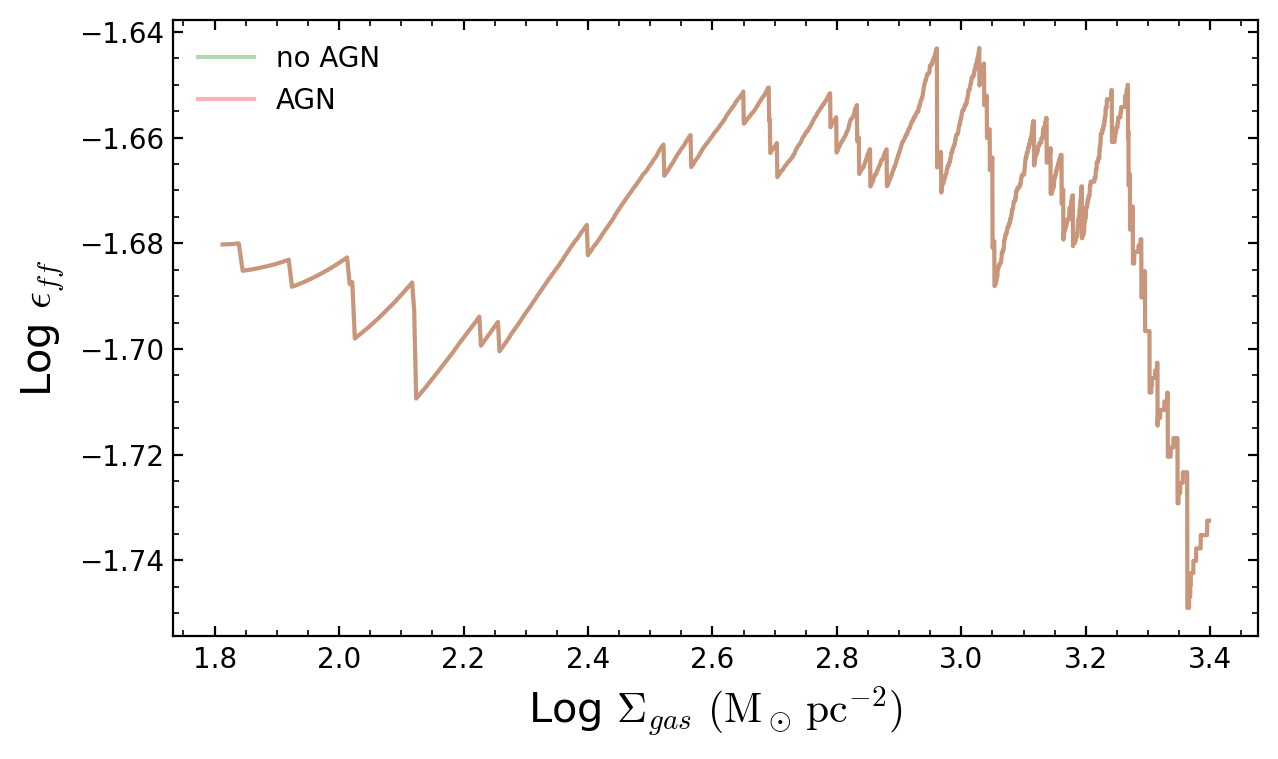

In [47]:
Sigma_range = np.linspace(65,2500, 2435)

fig, ax = plt.subplots(figsize=(7,4))
ax.plot(np.log10(Sigma_range), np.log10(Non_AGN), label= 'no AGN', c='green', alpha = 0.3)
ax.plot(np.log10(Sigma_range), np.log10(AGN), label= 'AGN', c='red', alpha = 0.3)
ax.set_xlabel(r"Log $\Sigma_{gas}$ $(\rm M_\odot\,pc^{-2})$", fontsize = 15)
ax.set_ylabel(r"Log $\epsilon_{ff}$", fontsize = 15)
ax.legend();

In [48]:
np.median(AGN), np.median(Non_AGN)

(0.021461476604549324, 0.021461476604549324)